## Preliminaries

In [4]:
# Install Gurobi
%pip install gurobipy 

# Obtain academic license from: https://www.gurobi.com/downloads/end-user-license-agreement-academic/ 

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import the necessary packages
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import csv

import copy # To make deep copies
import random # To shuffle a list, randomly reorganize entries

In [6]:
# To use the Birkhoff-von-Neumann decomposition algorithm
%pip install birkhoff

from birkhoff import birkhoff_von_neumann_decomposition as decomp
    # Documentation of the package: https://birkhoff.readthedocs.io/en/latest/

Note: you may need to restart the kernel to use updated packages.


In [7]:
from itertools import permutations
    # Used to list all permutations for the function that evaluates the strategy-proofness of the procedure.

## Define classes

In [8]:
# Create a class that describes the data instances
class Data:
    # Define the initialization of an object from this class
    # This function takes the file name of the instance as an input, and will read the data
    # 'self' refers to the current instance of the class
    # 'which_type_of_file' is a string that determines how the input file will be read
        # 'list': If it simply contains the preferences
        # 'rank': If it contains for each topic on which position in the preference profile it is
            # Used for the Uruguayan data
    def __init__(self, file_name, which_type_of_file: str):
        # Name of the file
        self.file_name = file_name 
        
        # Initialize the number of agents (will be modified in method 'read_file')
        self.n = -1    
        
        #self.pref will contain preferences of the families
        #self.pref[0][0] is the first preference of the first familie, for example
        
        # IDs of apartments
        self.ID_apartment = []
        
        # IDs of families
        self.ID_family = []
        
        # Call a function that reads the file
        if (which_type_of_file == 'list'):
            self.read_file_list(file_name)
        elif (which_type_of_file == 'rank'):
            self.read_file_rank(file_name)
        else:
            print("\n\n CAREFUL: the entered string is not valid!")
            print("\tPlease specify which type of file you want to read by entering 'list' or 'rank'")
         
    # Methods that reads file with name 'file_name'
    def read_file_list(self, file_name):
        with open(file_name) as file:
            csv_reader = csv.reader(file, delimiter=',')
            
            # On the second line, the third cell contains the number of agents
            rows = list(csv_reader)
            self.n = int(rows[1][1])
            
            self.agents = range(self.n)
            
            # On the third line, we store the names of the apartments
            for i in range(1,self.n+1):
                self.ID_apartment.append(rows[2][i])
               
            # Create empty preference matrix
            self.pref = np.zeros(shape=(self.n, self.n), dtype=np.int8)
            
            # Add the preferences to 'self.pref'
            counter = 0
            for i in range(3,len(rows)):
                # Store the ID of the family
                self.ID_family.append(rows[i][0])
                
                # Store the preferences
                for j in range(1,self.n + 1):
                    self.pref[counter][j-1] = rows[i][j]
                counter = counter + 1
    
    def read_file_rank(self, file_name):
        with open(file_name) as file:
            csv_reader = csv.reader(file, delimiter=',')
            
            # On the second line, the third cell contains the number of agents
            rows = list(csv_reader)
            self.n = int(rows[1][1])
            
            self.agents = range(self.n)
            
            # On the third line, we store the names of the apartments
            for i in range(1,self.n+1):
                self.ID_apartment.append(rows[2][i])
               
            # Create empty preference matrix
            self.pref = np.zeros(shape=(self.n, self.n), dtype=np.int8)
            
            # Add the preferences to 'self.pref'
            counter = 0
            for i in range(3,len(rows)):
                # Store the ID of the family
                self.ID_family.append(rows[i][0])
                
                # Store the preferences
                for j in range(1,self.n + 1):
                    self.pref[counter][int(rows[i][j])-1] = j
                counter = counter + 1
                    
    # Choose what is being shown for the command 'print(MyData)', where 'MyData' is an instance of the class 'Data'
    def __str__(self):
        s ="The data instance has the following properties: \n"
        s += f"\n\t{self.n} agents.\n\n \tPREFERENCES:\n"
        for i in range(0,self.n):
            s+= f"\t{self.ID_family[i]}\t"
            for j in range(0, self.n):
                s+=f"{self.pref[i][j]} "
            s +="\n"
        return s

In [9]:
class Solution_report:
    # This class will be return by the function Rawls
    def __init__(self, MyData: Data, assignment: np.ndarray, label: str):
        # 'label' will be used for the plots and the exporting
            # if 'label' is 'Rawls', all titles will refer to 'Rawls'
            # if 'label' is 'PS', all titles will refer to 'PS'
        
        self.file_name = MyData.file_name[:-4]
        self.MyData = MyData
        self.assignment = assignment
        self.label = label
        
        names = []
        for i in MyData.agents:
            names.append("Choice {}".format(i + 1))
        
        # Same as assignment, but ranked in decreasing order of preference
        self.assignment_ranked = np.zeros(shape=(MyData.n, MyData.n), dtype = np.float64)
        for i in MyData.agents:
            for j in MyData.agents:
                self.assignment_ranked[i][j] = assignment[i][MyData.pref[i][j]-1]
        #self.assignment_ranked = pd.DataFrame(ranked, columns = names)
        
        # Calculate the cumulative probabilities of for agent i of being assigned to choice j, ..., n.
        self.p = np.zeros(shape=(MyData.n, MyData.n), dtype = np.float64)
        for i in MyData.agents:
            for j in MyData.agents:
                for k in range(j,MyData.n):
                    self.p[i][j] += assignment[i][MyData.pref[i][k]-1] # CAREFUL! -1 is needed because of different indexing!
        
        #self.p = pd.DataFrame(p, columns = names) 
    
        # Export assignment
        self.export_assignment()
    
    # Function to find the decomposition of 'self.assignment'
    def find_decomposition(self):
        print("\nThe possible error below originates from the package 'Birkhoff' that is used to find a decomposition")
        print("This error can be safely ignored.")
        
        # Contains the decomposition that is found
        self.decomposition = decomp(self.assignment)
        
        # Contains the coefficients of the matchings in the decomposition
        self.decomp_coeff = []
        
        # Contains the matchings in the decomposition
        self.decomp_matchings = []
        
        # Add all coefficients and matchings to the correct arrays
        for i in range(0,len(self.decomposition)):
            self.decomp_coeff.append(self.decomposition[i][0])
            self.decomp_matchings.append(self.decomposition[i][1])
            
       
            
    # Function to print the decomposition    
    def print_decomposition(self):     
        # Find a decomposition
        self.find_decomposition() 
        
        counter = 1
        for i in range(0,len(self.decomposition)):
            print("M_{}: coeff = {}".format(i+1, self.decomp_coeff[i]))
            s = ""
            for j in range(0,self.MyData.n):
                s += "\t"
                for k in range(0,self.MyData.n):
                    s += f"{int(self.decomp_matchings[i][j][k])} "
                s += "\n"
            print(s)
    
    # Visualize the assignment in different ways
    def visualize(self):
        # To export the figures, check if the correct folder exists:
        if os.path.exists("Results") == False:
            # If not, create folder
            os.makedirs("Results")
        
        s = os.path.join("Results", "Visualisations")
        if os.path.exists(s) == False:
            # If not, create folder
            os.makedirs(s)
        
        s = os.path.join("Results", "Visualisations",self.file_name)
        if os.path.exists(s) == False:
            os.makedirs(s)
            
        
        path = "Results/Visualisations/"
        # The assignment itself
        sns.set(rc = {'figure.figsize':(MyData.n,MyData.n/1.5)})
        p = sns.heatmap(self.assignment, cmap = "Blues", annot=True, yticklabels = MyData.ID_family, xticklabels = MyData.ID_apartment)
        p.set_xlabel("Apartments", fontsize = 15)
        p.set_ylabel("Families", fontsize = 15)
        if self.label == 'Rawls':
            name = path + self.file_name + "/" + "Rawls_Assignment" + "_" + self.file_name + ".pdf"
            p.set_title("Rawlsian assignment", fontsize = 20)
        else:
            name = path + self.file_name + "/" + self.label + "_Assignment" + "_" + self.file_name + ".pdf"
            title = self.label + " assignment"
            p.set_title(title, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        
        # Assignment, ranked by preference
        plt.figure()
        sns.set(rc = {'figure.figsize':(MyData.n,MyData.n/1.5)})
        p = sns.heatmap(self.assignment_ranked, cmap = "BuGn", annot=True, yticklabels = MyData.ID_family, xticklabels = range(1,MyData.n + 1))
        p.set_xlabel("Preference", fontsize = 15)
        p.set_ylabel("Families", fontsize = 15)
        if self.label == 'Rawls':
            name = path + self.file_name + "/" + "Rawls_Ranked assignment" + "_" + self.file_name + ".pdf"
            p.set_title("Rawlsian assignment: ranked by decreasing preference", fontsize = 20)
        else:
            name = path + self.file_name + "/" + self.label + "_Ranked assignment" + "_" + self.file_name + ".pdf"
            title = self.label + " assignment: ranked by decreasing preference"
            p.set_title(title, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        
        plt.figure()
        # Probabilities by preference
        sns.set(rc = {'figure.figsize':(MyData.n,MyData.n/1.5)})
        p = sns.heatmap(self.p, cmap = "Oranges", annot=True, yticklabels = MyData.ID_family, xticklabels = range(1,MyData.n + 1))
        p.set_xlabel("Preference", fontsize = 15)
        p.set_ylabel("Families", fontsize = 15)
        if self.label == 'Rawls':
            name = path + self.file_name + "/" + "Rawls_Cumulative assignment" + "_" + self.file_name + ".pdf"
            p.set_title("Rawlsian assignment: cumulative probabilities by preference", fontsize = 20)
        else:
            name = path + self.file_name + "/" + self.label + "_Cumulative assignment" + "_" + self.file_name + ".pdf"
            title = self.label + " assignment: cumulative probabilities by preference"
            p.set_title(title, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
    
    # Save the assignment to the correct subdirectory
    def export_assignment(self):
        if os.path.exists("Results") == False:
            # If not, create folder
            os.makedirs("Results")

        s = os.path.join("Results", "Assignments")
        if os.path.exists(s) == False:
            # If not, create folder
            os.makedirs(s)

        s = os.path.join("Results", "Assignments",self.file_name)
        if os.path.exists(s) == False:
            os.makedirs(s)
        
        name = "Results/Assignments/" + self.file_name + "/" + self.label + "_" + self.file_name + ".csv"
        np.savetxt(name, self.assignment, delimiter=",")
        
    # Choose what is being shown for the command 'print(Sol)', where 'Sol' is an instance of the class 'Solution_report'
    def __str__(self):
        
        return s
        

## Define functions
The boolean matrix $N \in \{0,1\}^{n^2}$ will store for which agents and which preferences the assignment probabilities are already found. $N_{ji} = 1$ if agent $i$'s probabilities are found for preferences $j,\ldots,n$.

Similarly, matrix $b\in[0,1]^{n^2}$ contains the values of the probabilities that are already fixed. If $b_{ji} = \alpha$, this means that agent $i$ is assigned to an object with preference $j,\ldots,n$ with a probability of $\alpha$, i.e., $\sum_{k=j}^nx_{ik} = \alpha$.

### Which functions do what?
* Rawls: calculates 'Rawls' assignment using the algorithm with repetitive LPs
* PS_eating: calculates the PS assignment using the eating algorithm
* Lex_by_pref_front: calculates an assignment that for each preference p, maximizes the probability of being assigned to an object of preference 1..p with repetitive LPs (the reverse of the Rawls algorithm)




In [10]:
def Rawls(MyData: Data):   
    # Create a Gurobi model to optimize the linear model
    m = gp.Model("Rawls")
    m.setParam('OutputFlag', 0)  # Removes output solver, comment out to see optimization info
    
    # Decision variables
    # CAREFUL! Indices start from zero, so x[0][5] is the probability that agent 1 is assigned to object 6.
    x = m.addVars(MyData.agents, MyData.agents, vtype=GRB.CONTINUOUS, lb = 0.0, ub = 1.0, name="x")
        # x[i][j] is the probability with which agent i is assigned to object j
        
    b_star = m.addVar(vtype=GRB.CONTINUOUS, name = "b_star")
    epsilon = m.addVar(vtype=GRB.CONTINUOUS, name = "epsilon")
    
    # Objective function
    m.setObjective(b_star, GRB.MINIMIZE)
    
    # Add general constraints to obtain a feasible assignment
    for i in MyData.agents:
        Expr = 0.0
        for j in MyData.agents:
            Expr += x[i,j]
        m.addConstr(Expr == 1, name="FeasAgent_{}".format(i))
        
    for i in MyData.agents:
        Expr = 0.0
        for j in MyData.agents:
            Expr += x[j,i]
        m.addConstr(Expr == 1, name="FeasObject_{}".format(i))
    m.write('Rawls.lp')    
    
    # Explanation of the following variables, see text above
    # Define matrix 'N'
    N = np.zeros(shape=(MyData.n, MyData.n), dtype=np.bool8)
    
    # Similarly, define matrix 'b'
    b = np.zeros(shape=(MyData.n, MyData.n), dtype=np.float64)
    
    # We create dictionaries that will store the constraints. This will allow us to easily add and remove constraints
    Constr_BoundAgent = dict()
    Constr_FixAgent=dict()
    b_found = 0.0
    
    # Start from the last preference
    for j in range(MyData.n - 1, -1, -1):
        #print("\nPref {}\n".format(j+1))
        # Start by upper bounding \sum_{k=j}^{n} x_{i,k} by 'b_star' for all agents i
        for i in MyData.agents:
            #print("\tLastPref Ag. {} = {}".format(i+1, MyData.pref[i][j]))
            Expr = 0.0
            for k in range(j,MyData.n):
                Expr += x[i,MyData.pref[i][k]-1] #CAREFUL! SHIFT in indices here, start at 1 in data, but at variables start at 0 in Python!
            Constr_BoundAgent[i] = m.addConstr(Expr <= b_star, name = "BoundAgent_{}".format(i))
        m.write('Rawls.lp')
        
        # Continue until all agents' probabilities for this preference are fixed:
        
        # 'newly_fixed' contains the agents for which the probabilities are newly fixed in the previous iteration to 'b_found'
        newly_fixed = np.zeros(MyData.n, dtype=np.bool8)
        
        counter = 26
        #while(counter <= MyData.n):
        while (np.sum(N[j]) != MyData.n):            
            # Reset 'newly_fixed'
            newly_fixed = np.zeros(MyData.n, dtype=np.bool8)
            
            # Solve the upper linear program
            m.write('Rawls.lp')
            m.optimize()
            b_found = b_star.X
            #print("\t{}".format(b_found))
            
            # If this value is zero, then we can move on to the next preference
            if (b_found == 0):
                # We first replace all remaining "BoundAgent" constraint by "FixAgent" constraints
                for i in MyData.agents:
                    if N[j][i] == 0:
                        # Add constraints for agents that were newly fixed in the previous iteration...
                        Expr = 0.0
                        for k in range(j,MyData.n):
                            Expr += x[i,MyData.pref[i][k]-1]
                        Constr_FixAgent[i,j] = m.addConstr(Expr == b_found, name = "FixAgent_{},{}".format(i,j+1))

                        # ... and remove the correspond 'BoundAgent' constraints that linked their probability with 'b_star'
                        m.remove(Constr_BoundAgent[i])

                        # Store that we fixed the probabilities to zero in 'N'
                        N[j][i] = 1
                        
            else:
                # Temporarily fix 'b_star' to 'b_found'
                Constr_Fix_b_star = m.addConstr(b_star == b_found, name = "Fix_b_star")
                
                # Go through all agents that are not yet fixed:
                for i in MyData.agents:
                    if (N[j][i] == 0):
                        # Now we solve the lower linear model.
                        
                        # Change the objective function
                        m.setObjective(epsilon, GRB.MAXIMIZE)
                        
                        # Add temporary constraint to bound probabilities of object j,...,n for agent i by b_found-epsilon
                        Expr = 0.0
                        for k in range(j,MyData.n):
                            Expr += x[i,MyData.pref[i][k]-1]
                        temporary = m.addConstr(Expr <= b_found - epsilon, name = "Temporary")
                        
                        m.optimize()
                        
                        epsilon_found = epsilon.X
                        
                        # Remove constraint 'temporary' again
                        m.remove(temporary)
                        
                        if epsilon_found == 0.0:
                            # This means that we should fix the probability for agent i
                            newly_fixed[i] = 1
                            
                            # Store that the value of the agent is fixed in this iteration
                            N[j][i] = 1
                            
                            # And store to which value it is fixed
                            b[j][i] = b_found
                        
                # Remove constraint that fixes 'b_star' to b_found'
                m.remove(Constr_Fix_b_star)
                
                # Set the objective function again to 'b_star'
                m.setObjective(b_star, GRB.MINIMIZE)
                
                # Add constraints for the agents that are fixed:
                for i in MyData.agents:
                    if newly_fixed[i] == 1:
                        # Add constraints for agents that were newly fixed in this iteration...
                        Expr = 0.0
                        for k in range(j,MyData.n):
                            Expr += x[i,MyData.pref[i][k]-1]
                        Constr_FixAgent[i,j] = m.addConstr(Expr == b_found, name = "FixAgent_{},{}".format(i,j+1))

                        # ... and remove the correspond 'BoundAgent' constraints that linked their probability with 'b_star'
                        m.remove(Constr_BoundAgent[i])
                        
                        #print("\t\tAgent {}.".format(i+1))           
                
    
    
    # The final assignment is the solution of the last solved linear program
    assignment = np.zeros(shape = (MyData.n, MyData.n), dtype = np.float64)
    for i in MyData.agents:
        for j in MyData.agents:
            assignment[i][j] = x[i,j].X
    
    Sol = Solution_report(MyData, assignment, "Rawls")
            
    return Sol

In [11]:
# Code PS from Joaquin
# Credits to: https://github.com/abclark/constrained_birkhoff_von_neumann/blob/master/probabilistic_serial_mechanism.py

import copy

#TOLERANCE = 1.0e-10
TOLERANCE = 1.0e-5


def probabilistic_serial_mechanism(R, m):
    # define an empty dictionary to store the solution, and copies of R and m
    P={}
    Q = copy.deepcopy(R)
    t = copy.deepcopy(m)
    # give the empty dictionary P the structure of the solution
    for key, value in Q.items():
        P[key]= [0]*len(value)
    # eat probability mass while it remains
    counter = 1
    while any(Q[key] != [] for key,values in Q.items()):
        # if an object has no remaining probability mass, remove it from the rank order lists
        for key,value in Q.items():
            Q[key] = [i for i in value if t[i] > TOLERANCE and P[key][i] < 1-TOLERANCE]
        # define a zero vector whose dimension equals the number of objects
        y = np.zeros(len(t))
        # define a vector of ones, one for each agent
        x = np.ones(len(Q.items()))
        # count how many agents rank each object first (under updated rank order lists)
        # for each agent's preferred object (under updated rank order lists), 
        # record in x how much more of that object's probability mass they can consume
        for key,value in Q.items():
            if value != []:
                y[value[0]] += 1
                x[key] = 1 - P[key][value[0]]
        # define a vector recording time taken until each object's probability mass is depleted without intervention
        z = [max(i,0.000001)/max(j,0.0000001) for i,j in zip(t,y)]
        # update probability masses m and record probability consumed in P
        for key,value in Q.items():
            if value != []:
                t[value[0]] -= min(min(z), min(x))
                P[key][value[0]] += min(min(z), min(x))
        # if all probaility masses are nil, the process is done—return the solution
            # else:
                # print([P,np.array([value for key, value in P.items()])])
    return P
    

In [12]:
def PS_eating(MyData: Data):
    # Calculate the PS assignment using the code by 
    # https://github.com/abclark/probabilistic_serial_mechanism 
    
    # First we should translate the input to a dictionary in which the preferences are a list.
    pref_dict = {}
    for i in MyData.agents:
        pref_dict[i] = MyData.pref[i].tolist()
        
        # CAREFUL! The indexing should be changed, because the algorithm requires the objects to start from zero
        for j in MyData.agents:
            pref_dict[i][j] = pref_dict[i][j] - 1
     
    m = [1] * MyData.n
    assignment_dictionary = probabilistic_serial_mechanism(pref_dict, m)
    
    # Now we have to translate this back to the format we are used to, which is a numpy array
    assignment = np.zeros(shape = (MyData.n, MyData.n), dtype = np.float64)
    for i in MyData.agents:
        for j in MyData.agents:
            assignment[i][j] = assignment_dictionary[i][j]
    
    Sol = Solution_report(MyData, assignment, "PSeating")

    return Sol

In [13]:
def Lex_by_pref_front(MyData: Data):
    # This algorithm is the same as Rawls, but by changing the order
    # and the direction of the inequalities
    
    # DISCLAIMER: the result is NOT identical to the result by the PS mechanism!
    
    # Create a Gurobi model to optimize the linear model
    m = gp.Model("Rawls")
    m.setParam('OutputFlag', 0)  # Removes output solver, comment out to see optimization info
    
    # Decision variables
    # CAREFUL! Indices start from zero, so x[0][5] is the probability that agent 1 is assigned to object 6.
    x = m.addVars(MyData.agents, MyData.agents, vtype=GRB.CONTINUOUS, lb = 0.0, ub = 1.0, name="x")
        # x[i][j] is the probability with which agent i is assigned to object j
        
    b_star = m.addVar(vtype=GRB.CONTINUOUS, name = "b_star")
    epsilon = m.addVar(vtype=GRB.CONTINUOUS, name = "epsilon")
    
    # Objective function
    m.setObjective(b_star, GRB.MAXIMIZE)
    
    # Add general constraints to obtain a feasible assignment
    for i in MyData.agents:
        Expr = 0.0
        for j in MyData.agents:
            Expr += x[i,j]
        m.addConstr(Expr == 1, name="FeasAgent_{}".format(i))
        
    for i in MyData.agents:
        Expr = 0.0
        for j in MyData.agents:
            Expr += x[j,i]
        m.addConstr(Expr == 1, name="FeasObject_{}".format(i))
    m.write('PS.lp')    
    
    # Explanation of the following variables, see text above
    # Define matrix 'N'
    N = np.zeros(shape=(MyData.n, MyData.n), dtype=np.bool8)
    
    # Similarly, define matrix 'b'
    b = np.zeros(shape=(MyData.n, MyData.n), dtype=np.float64)
    
    # We create dictionaries that will store the constraints. This will allow us to easily add and remove constraints
    Constr_BoundAgent = dict()
    Constr_FixAgent=dict()
    b_found = 0.0
    
    # Start from the FIRST preference
    for j in MyData.agents:
        #print("\nPref {}\n".format(j+1))
        # Start by LOWER bounding \sum_{k=j}^{n} x_{i,k} by 'b_star' for all agents i
        for i in MyData.agents:
            Expr = 0.0
            for k in range(j+1):
                Expr += x[i,MyData.pref[i][k]-1] #CAREFUL! SHIFT in indices here, start at 1 in data, but at variables start at 0 in Python!
            Constr_BoundAgent[i] = m.addConstr(Expr >= b_star, name = "BoundAgent_{}".format(i))
        m.write('PS.lp')
        
        # Continue until all agents' probabilities for this preference are fixed:
        
        # 'newly_fixed' contains the agents for which the probabilities are newly fixed in the previous iteration to 'b_found'
        newly_fixed = np.zeros(MyData.n, dtype=np.bool8)
        
        counter = 26
        #while(counter <= MyData.n):
        while (np.sum(N[j]) != MyData.n):            
            # Reset 'newly_fixed'
            newly_fixed = np.zeros(MyData.n, dtype=np.bool8)
            
            # Solve the upper linear program
            m.write('PS.lp')
            m.optimize()
            b_found = b_star.X
            #print("\t{}".format(b_found))
            
            # Temporarily fix 'b_star' to 'b_found'
            Constr_Fix_b_star = m.addConstr(b_star == b_found, name = "Fix_b_star")

            # Go through all agents that are not yet fixed:
            for i in MyData.agents:
                if (N[j][i] == 0):
                    # Now we solve the lower linear model.

                    # Change the objective function
                    m.setObjective(epsilon, GRB.MAXIMIZE)

                    # Add temporary constraint to bound probabilities of object j,...,n for agent i by b_found-epsilon
                    Expr = 0.0
                    for k in range(j+1):
                        Expr += x[i,MyData.pref[i][k]-1]
                    temporary = m.addConstr(Expr >= b_found + epsilon, name = "Temporary")

                    m.optimize()

                    epsilon_found = epsilon.X

                    # Remove constraint 'temporary' again
                    m.remove(temporary)

                    if epsilon_found == 0.0:
                        # This means that we should fix the probability for agent i
                        newly_fixed[i] = 1

                        # Store that the value of the agent is fixed in this iteration
                        N[j][i] = 1

                        # And store to which value it is fixed
                        b[j][i] = b_found

            # Remove constraint that fixes 'b_star' to b_found'
            m.remove(Constr_Fix_b_star)

            # Set the objective function again to 'b_star'
            m.setObjective(b_star, GRB.MAXIMIZE)

            # Add constraints for the agents that are fixed:
            for i in MyData.agents:
                if newly_fixed[i] == 1:
                    # Add constraints for agents that were newly fixed in this iteration...
                    Expr = 0.0
                    for k in range(j+1):
                        Expr += x[i,MyData.pref[i][k]-1]
                    Constr_FixAgent[i,j] = m.addConstr(Expr == b_found, name = "FixAgent_{},{}".format(i,j+1))

                    # ... and remove the correspond 'BoundAgent' constraints that linked their probability with 'b_star'
                    m.remove(Constr_BoundAgent[i])

                    #print("\t\tAgent {}.".format(i+1))           

    
    # The final assignment is the solution of the last solved linear program
    assignment = np.zeros(shape = (MyData.n, MyData.n), dtype = np.float64)
    for i in MyData.agents:
        for j in MyData.agents:
            assignment[i][j] = x[i,j].X
    
    Sol = Solution_report(MyData, assignment, "PSalgorithm")
            
    return Sol

## Code execution
To read in a data file, there are two options:
* "rank": each column of the file represents an object, and the corresponding number indicated the position of the object in the preference list of an agent. Preference list 3,1,2 refers in this setting to object b being most preferred, then object c, and object a is least preferred.
* "list": the objects are listed from most preferred to least preferred. Preference list 3,1,2 refers to object c being most preferred, then object a, and object b being least preferred. 

In [14]:
file_name = "Example_SP_axioms.csv"
MyData = Data(file_name, "list")
print(MyData)

The data instance has the following properties: 

	3 agents.

 	PREFERENCES:
	F1	3 2 1 
	F2	2 3 1 
	F3	2 3 1 



In [15]:
Sol = Rawls(MyData)

# The object 'Sol' now contains the solution, it is an object from the class 'Solution_report'
# Sol contains the following three matrices:
    # Sol.assignment: the assignment. 'Sol[i][j]' represents the probability;
        # with which agent i+1 is assigned to object j+1 (careful for the indices)
    # Sol.assignment_ranked: same as assignment, but in decreasing order of preference
    # Sol.p: the cumulative assignment probabilities by preference;
        # 'Sol.p[i][j]' contains the probability with which agent i+1 is assigned to an object of preference j+1,...,n,
        # i.e., Sol.p[i][j] = \sum_{j=k}^{n} x[i][k]
        

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-15


## Analysis
We will first plot the assignment, and then the cumulative probabilities by decreasing probability

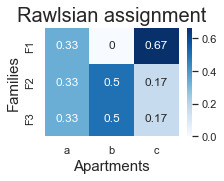

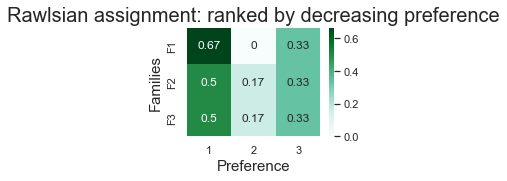

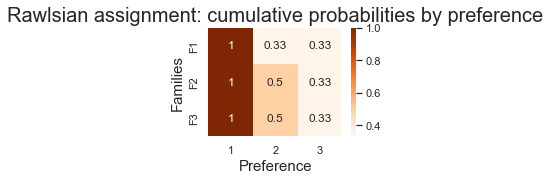

In [16]:
Sol.visualize()

In [17]:
# Print a decomposition of the assignment
Sol.print_decomposition()


The possible error below originates from the package 'Birkhoff' that is used to find a decomposition
This error can be safely ignored.
M_1: coeff = 0.16666666666666663
	1 0 0 
	0 1 0 
	0 0 1 

M_2: coeff = 0.33333333333333337
	0 0 1 
	0 1 0 
	1 0 0 

M_3: coeff = 0.16666666666666663
	1 0 0 
	0 0 1 
	0 1 0 

M_4: coeff = 0.33333333333333326
	0 0 1 
	1 0 0 
	0 1 0 



C:\Users\u0131528\Anaconda3\lib\site-packages\birkhoff.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  P[list(zip(*(matches.items())))] = 1
